# Fokker-Planck Equation I: Advection

This notebooks looks at the functionality of the Fokker Planck integrator for the diffusion-free case, in which only advection is present in the dynamics. For th sake of simplicity, we look only at a one-dimensional scenario in this notebook.

Effectively, this means we will be simulating the dynamics of the equation

$$ \frac{\partial p(x, t)}{\partial t} = -\beta D \frac{\partial}{\partial x}\left[ F(x, t) p(x, t) \right] $$

Further, we will look specifically at the constant force case, where $F(x, t) = k$ so that the RHS of the equation is $-\beta D k \partial_x p(x, t)$

For a given initial condition $f(x)$, in such a situation the analytical solution to the advection equation is $f(x - vt)$ (as the advection equation is the wave equation) where the velocity of propagation is given by the prefactor of the derivative term, which, in this case, is $\beta D k$. For the sake of simplicity, we will take $\beta = D = 1$ in this notebook.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# The 1D integrator is contained in the Integrator module
from FPE import Integrator

# Define dynamics parameters
D = 1.0
dt = 0.001
dx = 0.01
force = 0.5
x_array = np.arange(-1, 1, dx)

# To start, initialize an integrator object,
fpe = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="periodic")

fpe.__dict__.keys()



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion

		Sparse matrix methods preferred...


dict_keys(['D', 'dt', 'diffScheme', 'adScheme', 'BC', 'splitMethod', 'constDiff', 'output', 'sparTest', 'workAccumulator', 'workTracker', 'powerTracker', 'dx', 'N', 'prob', 'xArray', 'expImp', 'AMat', 'BMat', 'CMat'])

In [48]:
# Now, we can initialize the system with a Gsassian distribution using hthe build-in initializer
init_var = 1 / 16
fpe.initializeProbability(0, init_var)


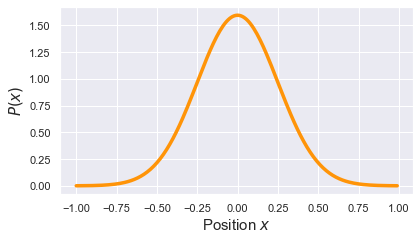

In [49]:
# We can plot the initial probably
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, fpe.prob, linewidth=3.5, color=sns.xkcd_rgb["tangerine"])
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x)$", fontsize=15)
plt.tight_layout()
plt.show()

In [50]:
# We can check the normalization by integrating, this is a probability
# density function, so \int p(x) dx = 1
import scipy.integrate as si

np.round(si.trapz(fpe.prob, fpe.xArray), 4)

1.0

In [51]:
# Now to simulate the advection, we cant ctually call any of the high-level
# integration routines, but we can simulate the advection-alone dynamics by
# accessing the _advection_step internal function. By default it makes use of
# the 2-step Lax-Wendroff algorithm to update the probability.

#To do this, however, we need to supply force parameters and a force function
# manually (typically, this could be globally set and then)
from FPE.forceFunctions import constantForce

# We also need to check the CFL criterion for these integration parameters
fpe.check_CFL([force], constantForce)



		CFL criterion satisfied, CFL --> 0.05




True

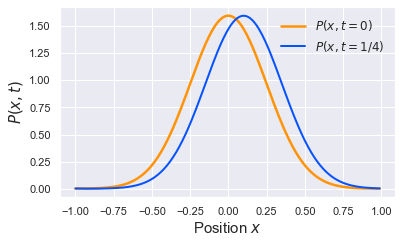

In [59]:
# So, the CFL is satisfied, so  we should be fine to run the dynamics

# This is a single step of the dynamics
fpe.initializeProbability(0, init_var)
init_prob = np.copy(fpe.prob)
# Now we can run the dynamics for time = 0.25
time = 0
total_time = 0.1
while time <= total_time:
    fpe.advectionUpdate([force], constantForce, fpe.dt)
    time += fpe.dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, init_prob, color=sns.xkcd_rgb["tangerine"], linewidth=2.5, label=r"$P(x, t=0)$")
ax.plot(fpe.xArray, fpe.prob, color=sns.xkcd_rgb["electric blue"], linewidth=2.0, label=r"$P(x, t=1/4)$")
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x, t)$", fontsize=15)
ax.legend(fontsize=12, frameon=False)

In [63]:
# We can calculate the distance that the mean of the distribution has moved as
# well to calculate the velocity of propagation

init_pos = fpe.xArray[np.argmax(init_prob)]
final_pos = fpe.xArray[np.argmax(fpe.prob)]
distance = final_pos - init_pos
velocity = distance / total_time
print(f"Velocity --> {np.round(velocity, 5)}")

Velocity --> 1.0
